In [4]:
# %% [markdown]
# # 2_lorann — Fit LoRANN and evaluate Recall@K with strict dataset integrity checks

import sys
from pathlib import Path

# Locate repo root by finding methods/lorann.py upward from CWD
p = Path.cwd().resolve()
repo_root = None
for _ in range(6):
    if (p / "methods" / "lorann.py").exists():
        repo_root = p
        break
    p = p.parent

if repo_root is None:
    raise FileNotFoundError("Could not find methods/lorann.py in parent directories.")

METHODS_DIR = (repo_root / "methods").resolve()
if str(METHODS_DIR) not in sys.path:
    sys.path.insert(0, str(METHODS_DIR))

from lorann import LorannIndex, compute_dataset_id  # noqa: E402

# Optional sanity check
import lorann as _lorann_mod  # noqa: E402
print("Using lorann from:", _lorann_mod.__file__)

REPO_ROOT = repo_root

# %%
import json
import time
from datetime import datetime

import numpy as np

# -------- dataset params (must match data notebook) --------
DIM = 300                     # 50 / 100 / 200 / 300
N_BASE = 400_000
NQ_TOTAL = 100_000
NQ_TEST = 20_000
TOP_K_GT = 50
SEED = 42

EVAL_KS = [10]                # e.g. [10] or [10, 50]
# ----------------------------------------------------------

# -------- LoRANN params --------
N_CLUSTERS = 1024
RANK = 32
N_PROBE = 16
CANDIDATE_COUNT = 2000
MAX_TRAIN_PER_CLUSTER = 2048
MIN_TRAIN_PER_CLUSTER = 64

KMEANS_MAX_ITER = 50
KMEANS_BATCH_SIZE = 8192
RANDOMIZED_SVD = True
SVD_OVERSAMPLE = 8
SVD_N_ITER = 2
# -------------------------------

REPO_ROOT = Path("..").resolve()
ARTIFACTS_DATA = (REPO_ROOT / "artifacts" / "data").resolve()
ARTIFACTS_RUNS = (REPO_ROOT / "artifacts" / "runs").resolve()
ARTIFACTS_RUNS.mkdir(parents=True, exist_ok=True)

print("ARTIFACTS_DATA:", ARTIFACTS_DATA)
print("ARTIFACTS_RUNS:", ARTIFACTS_RUNS)
print("DIM:", DIM, "| EVAL_KS:", EVAL_KS)

# %%
def _load_npz(path: Path) -> dict:
    with np.load(path, allow_pickle=True) as z:
        return {k: z[k] for k in z.files}

def _try_meta(z: dict) -> dict:
    s = z.get("meta", None)
    if s is None:
        return {}
    try:
        return json.loads(str(s.item()))
    except Exception:
        return {}

def _require_one_match(pattern: str, dim: int) -> Path:
    # Unique match (no "latest"). Raises if ambiguous.
    matches = sorted(ARTIFACTS_DATA.glob(pattern))
    # Force dim filter by filename
    matches = [p for p in matches if f"glove{dim}d_" in p.name]
    if len(matches) != 1:
        names = [p.name for p in matches]
        raise FileNotFoundError(f"Expected exactly 1 match for dim={dim}, pattern={pattern}. Found: {names}")
    return matches[0]

def resolve_dataset_paths(dim: int) -> tuple[Path, Path, Path]:
    # Primary: exact expected filenames (with __ds prefix)
    ds_glob = f"glove{dim}d_queries_N{N_BASE}_nq{NQ_TOTAL}_test{NQ_TEST}_seed{SEED}__ds*.npz"
    q_path = _require_one_match(ds_glob, dim)

    # Use dataset_id suffix from queries filename to lock base/gt
    ds_suffix = q_path.name.split("__ds")[-1].replace(".npz", "")
    base_glob = f"glove{dim}d_base_N{N_BASE}__ds{ds_suffix}.npz"
    gt_glob = f"glove{dim}d_gt_test_N{N_BASE}_nq{NQ_TEST}_k{TOP_K_GT}_seed{SEED}__ds{ds_suffix}.npz"

    base_path = _require_one_match(base_glob, dim)
    gt_path = _require_one_match(gt_glob, dim)
    return base_path, q_path, gt_path

base_path, queries_path, gt_path = resolve_dataset_paths(DIM)

base_z = _load_npz(base_path)
queries_z = _load_npz(queries_path)
gt_z = _load_npz(gt_path)

print("Base  :", base_path.name, "| keys:", list(base_z.keys()))
print("Queries:", queries_path.name, "| keys:", list(queries_z.keys()))
print("GT    :", gt_path.name, "| keys:", list(gt_z.keys()))

# %%
# Strict integrity checks
base_meta = _try_meta(base_z)
q_meta = _try_meta(queries_z)
gt_meta = _try_meta(gt_z)

ds_base = str(base_z.get("dataset_id", base_meta.get("dataset_id", "")))
ds_q = str(queries_z.get("dataset_id", q_meta.get("dataset_id", "")))
ds_gt = str(gt_z.get("dataset_id", gt_meta.get("dataset_id", "")))

if not (ds_base and ds_q and ds_gt):
    raise RuntimeError("Missing dataset_id in one of artifacts. Regenerate data with updated 0_data notebook.")

if not (ds_base == ds_q == ds_gt):
    raise RuntimeError(f"dataset_id mismatch: base={ds_base}, queries={ds_q}, gt={ds_gt}")

q_idx_test = queries_z["q_idx_test"]
gt_q_idx_test = gt_z["q_idx_test"]
if not np.array_equal(q_idx_test, gt_q_idx_test):
    raise RuntimeError("q_idx_test mismatch between queries and gt. Artifacts are not comparable.")

X = base_z["X"]          # (N, d)
Xn = base_z["Xn"]        # (N, d), unit norm
Q_train = queries_z["Q_train"]
Q_test = queries_z["Q_test"]
gt_ids = gt_z["gt_ids"]  # (nq_test, TOP_K_GT)

K_MAX = max(EVAL_KS)
if gt_ids.shape[1] < K_MAX:
    raise RuntimeError(f"GT has only {gt_ids.shape[1]} neighbors. Need >= {K_MAX}.")

print(f"DATASET_ID: {ds_q}")
print(f"X: {X.shape} | Q_train: {Q_train.shape} | Q_test: {Q_test.shape} | GT: {gt_ids.shape}")

# %%
def recall_at_k(pred_ids: np.ndarray, gt_ids: np.ndarray, k: int) -> float:
    k = int(k)
    k = min(k, pred_ids.shape[1], gt_ids.shape[1])
    hits = 0
    denom = pred_ids.shape[0] * k
    for i in range(pred_ids.shape[0]):
        hits += len(set(pred_ids[i, :k].tolist()) & set(gt_ids[i, :k].tolist()))
    return float(hits) / float(denom) if denom > 0 else 0.0

def ms_per_query(seconds: float, nq: int) -> float:
    return 1000.0 * float(seconds) / float(max(1, nq))

# %%
# Fit LoRANN
index = LorannIndex(
    n_clusters=N_CLUSTERS,
    rank=RANK,
    n_probe=N_PROBE,
    candidate_count=CANDIDATE_COUNT,
    max_train_per_cluster=MAX_TRAIN_PER_CLUSTER,
    min_train_per_cluster=MIN_TRAIN_PER_CLUSTER,
    seed=SEED,
    randomized_svd=RANDOMIZED_SVD,
    svd_oversample=SVD_OVERSAMPLE,
    svd_n_iter=SVD_N_ITER,
)

t0 = time.perf_counter()
index.fit(
    X=X,                 # corpus
    train_X=Q_train,     # query distribution proxy
    kmeans_max_iter=KMEANS_MAX_ITER,
    kmeans_batch_size=KMEANS_BATCH_SIZE,
)
t_fit = time.perf_counter() - t0

stats = getattr(index, "fit_stats_", {})
if stats:
    print("Fit stats:", stats)

print(f"Fit: {t_fit:.2f}s")

# %%
# Search (predict max K once, derive smaller K by prefix)
pred_k = int(max(EVAL_KS))
exclude_ids = q_idx_test.tolist()  # exclude self-match per query

t0 = time.perf_counter()
pred_ids, pred_scores = index.search_batch(
    Q_test,
    top_k=pred_k,
    candidate_count=CANDIDATE_COUNT,
    exclude_ids=exclude_ids,
)
t_search = time.perf_counter() - t0

print(f"Search: {t_search:.2f}s | {ms_per_query(t_search, Q_test.shape[0]):.3f} ms/query | pred_k={pred_k}")

for k in EVAL_KS:
    r = recall_at_k(pred_ids, gt_ids, k=int(k))
    print(f"Recall@{int(k)}: {r:.4f}")

# %%
# Save run artifact (locked to dataset_id)
ts = datetime.now().strftime("%Y%m%d_%H%M%S")
run_dir = ARTIFACTS_RUNS / "lorann" / f"ds{ds_q}"
run_dir.mkdir(parents=True, exist_ok=True)

run_path = run_dir / (
    f"{ts}__d{DIM}__k{pred_k}"
    f"__nlist{N_CLUSTERS}__probe{N_PROBE}__cand{CANDIDATE_COUNT}__r{RANK}"
    f"__trainmax{MAX_TRAIN_PER_CLUSTER}__trainmin{MIN_TRAIN_PER_CLUSTER}.npz"
)

run_meta = {
    "method": "lorann",
    "dataset_id": ds_q,
    "dim": int(DIM),
    "pred_k": int(pred_k),
    "eval_ks": [int(k) for k in EVAL_KS],
    "n_clusters": int(N_CLUSTERS),
    "rank": int(RANK),
    "n_probe": int(N_PROBE),
    "candidate_count": int(CANDIDATE_COUNT),
    "max_train_per_cluster": int(MAX_TRAIN_PER_CLUSTER),
    "min_train_per_cluster": int(MIN_TRAIN_PER_CLUSTER),
    "kmeans_max_iter": int(KMEANS_MAX_ITER),
    "kmeans_batch_size": int(KMEANS_BATCH_SIZE),
    "randomized_svd": bool(RANDOMIZED_SVD),
    "svd_oversample": int(SVD_OVERSAMPLE),
    "svd_n_iter": int(SVD_N_ITER),
    "fit_seconds": float(t_fit),
    "search_seconds": float(t_search),
    "ms_per_query": float(ms_per_query(t_search, Q_test.shape[0])),
    "fit_stats": stats,
}

np.savez_compressed(
    run_path,
    dataset_id=np.array(ds_q, dtype=np.str_),
    pred_ids=pred_ids.astype(np.int32, copy=False),
    pred_scores=pred_scores.astype(np.float32, copy=False),
    meta=np.array(json.dumps(run_meta), dtype=np.str_),
)

print("Saved run:", run_path)


Using lorann from: /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/methods/lorann.py
ARTIFACTS_DATA: /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/data
ARTIFACTS_RUNS: /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/runs
DIM: 300 | EVAL_KS: [10]
Base  : glove300d_base_N400000__ds989456bc6cc2e6ed.npz | keys: ['dataset_id', 'base_words', 'X', 'Xn', 'meta']
Queries: glove300d_queries_N400000_nq100000_test20000_seed42__ds989456bc6cc2e6ed.npz | keys: ['dataset_id', 'q_idx_all', 'q_idx_train', 'q_idx_test', 'Q_train', 'Q_test', 'Qn_train', 'Qn_test', 'meta']
GT    : glove300d_gt_test_N400000_nq20000_k50_seed42__ds989456bc6cc2e6ed.npz | keys: ['dataset_id', 'q_idx_test', 'gt_ids', 'gt_scores', 'meta']
DATASET_ID: 989456bc6cc2e6ed
X: (400000, 300) | Q_train: (80000, 300) | Q_test: (20000, 300) | GT: (20000, 50)
Fit stats: {'n_clusters': 1024, 'fallback_clusters': 628, 'fallback_frac': 0.61328125, 'avg_cluster_size': 390.625, 'avg_train_per_cl

REPO_ROOT      : /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project
ARTIFACTS_DATA : /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/data
ARTIFACTS_RUNS : /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/runs
Found run files: 4
Best LoRANN run per dimension (by Recall@10):


,dim,recall@10,ms_per_query,nlist,n_probe,candidate_count,rank,run_file
0,50,0.839235,1.040652,1024,16,2000,32,20251220_223250__d50__k10__nlist1024__probe16_...
1,100,0.887395,1.045796,1024,16,2000,32,20251220_223333__d100__k10__nlist1024__probe16...
2,200,0.816030,2.001110,1024,16,2000,32,20251220_223436__d200__k10__nlist1024__probe16...
3,300,0.757040,1.932720,1024,16,2000,32,20251220_223553__d300__k10__nlist1024__probe16...


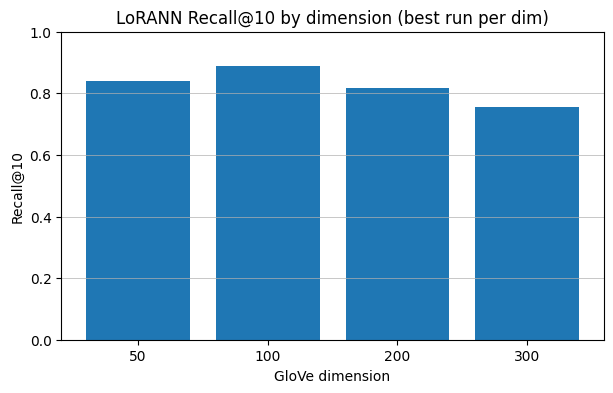

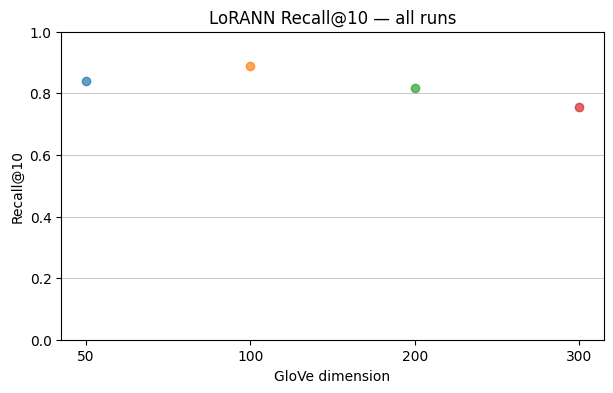

Saved: /Users/nslobodchuk/Projects/Tutorials/NLA/ann-nla-project/artifacts/runs/lorann_eval_summary.csv


In [5]:
# %% [markdown]
# # 4_eval_runs — Aggregate LoRANN runs and plot Recall@10 across GloVe dimensions
# Assumptions:
# - Runs are saved under: artifacts/runs/lorann/ds<DATASET_ID>/*.npz
# - Each run .npz contains: pred_ids, pred_scores (optional), dataset_id, meta (json string)
# - Ground truth is saved under: artifacts/data/glove{dim}d_gt_test_...__ds<DATASET_ID>.npz
# - GT .npz contains: gt_ids, q_idx_test, dataset_id

# %%
import json
import re
from pathlib import Path
from typing import Dict, Tuple, Optional, List

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# %%
# ---- Resolve repo root robustly (find artifacts/ or methods/lorann.py) ----
p = Path.cwd().resolve()
REPO_ROOT = None
for _ in range(8):
    if (p / "artifacts").exists() or (p / "methods" / "lorann.py").exists():
        REPO_ROOT = p
        break
    p = p.parent

if REPO_ROOT is None:
    raise FileNotFoundError("Could not locate repo root (expected artifacts/ or methods/lorann.py in parents).")

ARTIFACTS_DATA = (REPO_ROOT / "artifacts" / "data").resolve()
ARTIFACTS_RUNS = (REPO_ROOT / "artifacts" / "runs").resolve()

if not ARTIFACTS_DATA.exists():
    raise FileNotFoundError(f"Data artifacts dir not found: {ARTIFACTS_DATA}")
if not ARTIFACTS_RUNS.exists():
    raise FileNotFoundError(f"Runs artifacts dir not found: {ARTIFACTS_RUNS}")

print("REPO_ROOT      :", REPO_ROOT)
print("ARTIFACTS_DATA :", ARTIFACTS_DATA)
print("ARTIFACTS_RUNS :", ARTIFACTS_RUNS)

# %%
EVAL_K = 10
DIMS = [50, 100, 200, 300]  # expected dims

# %%
def _load_npz(path: Path) -> dict:
    with np.load(path, allow_pickle=True) as z:
        return {k: z[k] for k in z.files}

def _meta_dict(z: dict) -> dict:
    s = z.get("meta", None)
    if s is None:
        return {}
    try:
        return json.loads(str(s.item()))
    except Exception:
        return {}

def _get_dataset_id(z: dict) -> str:
    # Handles both stored dataset_id and meta["dataset_id"]
    if "dataset_id" in z:
        try:
            return str(z["dataset_id"].item())
        except Exception:
            return str(z["dataset_id"])
    m = _meta_dict(z)
    return str(m.get("dataset_id", ""))

def recall_at_k(pred_ids: np.ndarray, gt_ids: np.ndarray, k: int) -> float:
    """
    Set-based Recall@k averaged over queries:
      |pred ∩ gt| / k
    pred_ids may contain -1 placeholders.
    """
    k = int(k)
    k = min(k, pred_ids.shape[1], gt_ids.shape[1])
    if k <= 0:
        return 0.0

    hits = 0
    denom = pred_ids.shape[0] * k
    for i in range(pred_ids.shape[0]):
        p = pred_ids[i, :k]
        g = gt_ids[i, :k]
        # remove -1 from preds
        ps = set(int(x) for x in p.tolist() if int(x) >= 0)
        gs = set(int(x) for x in g.tolist() if int(x) >= 0)
        hits += len(ps & gs)
    return float(hits) / float(denom)

def parse_timestamp_from_name(name: str) -> Optional[str]:
    # expects prefix like YYYYMMDD_HHMMSS__
    m = re.match(r"^(\d{8}_\d{6})__", name)
    return m.group(1) if m else None

# %%
# ---- Cache GT per (dataset_id, dim) to avoid re-loading repeatedly ----
_gt_cache: Dict[Tuple[str, int], Tuple[np.ndarray, np.ndarray]] = {}

def load_gt(dataset_id: str, dim: int) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns (gt_ids, q_idx_test) for a given dataset_id and dim.
    """
    key = (dataset_id, int(dim))
    if key in _gt_cache:
        return _gt_cache[key]

    pattern = f"glove{dim}d_gt_test_*__ds{dataset_id}.npz"
    matches = sorted(ARTIFACTS_DATA.glob(pattern))

    if len(matches) != 1:
        # fallback: allow older filenames without __ds (best-effort)
        fallback = sorted([p for p in ARTIFACTS_DATA.glob(f"glove{dim}d_gt_test_*.npz") if f"__ds{dataset_id}" in p.name])
        matches = fallback

    if len(matches) != 1:
        raise FileNotFoundError(f"Expected 1 GT file for dim={dim}, dataset_id={dataset_id}. Found: {[p.name for p in matches]}")

    z = _load_npz(matches[0])
    ds = _get_dataset_id(z)
    if ds != dataset_id:
        raise RuntimeError(f"GT dataset_id mismatch for dim={dim}: expected {dataset_id}, got {ds}")

    gt_ids = z["gt_ids"]
    q_idx_test = z["q_idx_test"]
    _gt_cache[key] = (gt_ids, q_idx_test)
    return gt_ids, q_idx_test

# %%
# ---- Find all LoRANN run files ----
lorann_root = ARTIFACTS_RUNS / "lorann"
if not lorann_root.exists():
    raise FileNotFoundError(f"No LoRANN runs found: {lorann_root}")

run_files = sorted(lorann_root.rglob("*.npz"))
print("Found run files:", len(run_files))

# %%
rows: List[dict] = []

for rp in run_files:
    try:
        rz = _load_npz(rp)
        rmeta = _meta_dict(rz)
        dataset_id = _get_dataset_id(rz)

        if not dataset_id:
            # Skip legacy runs with no dataset_id
            continue

        dim = int(rmeta.get("dim", -1))
        if dim <= 0:
            # attempt parse from filename: "__d300__"
            m = re.search(r"__d(\d+)__", rp.name)
            dim = int(m.group(1)) if m else -1

        if dim not in DIMS:
            continue

        pred_ids = rz.get("pred_ids", None)
        if pred_ids is None:
            continue

        pred_k = int(rmeta.get("pred_k", pred_ids.shape[1]))
        if pred_k < EVAL_K or pred_ids.shape[1] < EVAL_K:
            # can't compute Recall@10 properly
            continue

        gt_ids, q_idx_test = load_gt(dataset_id, dim)

        # Optional: ensure q_idx_test length matches
        if gt_ids.shape[0] != pred_ids.shape[0]:
            # Most common cause: run used different nq_test or wrong dataset pairing
            continue

        r10 = recall_at_k(pred_ids, gt_ids, EVAL_K)

        ts = parse_timestamp_from_name(rp.name)
        ms_q = float(rmeta.get("ms_per_query", np.nan))
        cand = int(rmeta.get("candidate_count", rmeta.get("cand", -1))) if isinstance(rmeta, dict) else -1
        nprobe = int(rmeta.get("n_probe", -1))
        nlist = int(rmeta.get("n_clusters", -1))
        rank = int(rmeta.get("rank", -1))

        rows.append({
            "dataset_id": dataset_id,
            "dim": dim,
            "run_path": str(rp),
            "run_file": rp.name,
            "timestamp": ts,
            "recall@10": r10,
            "ms_per_query": ms_q,
            "nlist": nlist,
            "n_probe": nprobe,
            "candidate_count": cand,
            "rank": rank,
        })
    except Exception:
        # Skip any run that can't be parsed cleanly
        continue

df = pd.DataFrame(rows)
if df.empty:
    raise RuntimeError("No valid LoRANN runs found that can be evaluated for Recall@10.")

# Sort for readability
df = df.sort_values(["dim", "recall@10", "timestamp"], ascending=[True, False, False]).reset_index(drop=True)
df.head(10)

# %%
# Show the best run per dimension (highest Recall@10; tie-break latest timestamp)
best = (
    df.sort_values(["dim", "recall@10", "timestamp"], ascending=[True, False, False])
      .groupby("dim", as_index=False)
      .head(1)
      .sort_values("dim")
      .reset_index(drop=True)
)

print("Best LoRANN run per dimension (by Recall@10):")
display(best[["dim", "recall@10", "ms_per_query", "nlist", "n_probe", "candidate_count", "rank", "run_file"]])

# %%
# Plot Recall@10 across dims (best run per dim)
dims = best["dim"].to_list()
vals = best["recall@10"].to_list()

plt.figure(figsize=(7, 4))
plt.bar([str(d) for d in dims], vals)
plt.xlabel("GloVe dimension")
plt.ylabel("Recall@10")
plt.title("LoRANN Recall@10 by dimension (best run per dim)")
plt.ylim(0, 1)
plt.grid(axis="y", linewidth=0.5)
plt.show()

# %%
# Optional: if you want to see ALL runs per dimension (scatter)
plt.figure(figsize=(7, 4))
for d in sorted(df["dim"].unique()):
    sub = df[df["dim"] == d]
    plt.scatter([str(d)] * len(sub), sub["recall@10"].to_numpy(), label=str(d), alpha=0.7)
plt.xlabel("GloVe dimension")
plt.ylabel("Recall@10")
plt.title("LoRANN Recall@10 — all runs")
plt.ylim(0, 1)
plt.grid(axis="y", linewidth=0.5)
plt.show()

# %%
# Save aggregated results
out_csv = (ARTIFACTS_RUNS / "lorann_eval_summary.csv").resolve()
df.to_csv(out_csv, index=False)
print("Saved:", out_csv)